In this workshop we will play a bit with 2 popular frameworks for RL.

We will start with [RLlib](https://docs.ray.io/en/latest/rllib/index.html). It works the best for training on multiple environments.

In [1]:
!pip install 'ray[rllib]'

     |████████████████████████████████| 57.6 MB 1.8 MB/s 
     |████████████████████████████████| 119 kB 46.6 MB/s 
     |████████████████████████████████| 1.8 MB 44.1 MB/s 
     |████████████████████████████████| 124 kB 42.1 MB/s 


In [2]:
import os 
import ray
import ray.rllib.agents.dqn as dqn
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
np.random.seed(42)

Initialize Ray framework

In [4]:
ray.init(ignore_reinit_error=True)

{'metrics_export_port': 55454,
 'node_id': 'dd6b8e90c03c833d9a687e56eb634fa9342d7c28433ea81c9e1c1b55',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-12-15_14-22-25_969281_60/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-12-15_14-22-25_969281_60/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-12-15_14-22-25_969281_60',
 'webui_url': None}

## DQN Agent for CartPole-v0

We will train rl agent to solve gym CartPole enviroment.

Gym enviroments are just simple "games" to test if rl algoritms works

## CartPole-v1 environment

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

![CartPole.png](https://miro.medium.com/max/1200/1*oMSg2_mKguAGKy1C64UFlw.gif)

[official documentation website](https://gym.openai.com/envs/CartPole-v1/).

Rllib requies enviroment to accept config argument in constructor, so we add a small wrapper CartpoleRlib

In [5]:
class CartpoleRlib(gym.Env):
    def __init__(self, config):
        self.env = gym.make("CartPole-v1")
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def reset(self):
        return np.array(self.env.reset())

    def step(self, action):
        return np.array(self.env.step(action))

    def close(self):
        self.env.close()

## Training DQN agent
You could train agents using rlib Trainer classes.

It requres 2 paramiters: target enviroment and algorithm configuration.

For now we will just use default config.
I encourage you to play with parameters and see how it changes performace.


In [6]:
config = dqn.DEFAULT_CONFIG

In [7]:
# Create trainer for controlling all training process
trainer = dqn.DQNTrainer(config = config, env = CartpoleRlib)

2021-12-15 14:30:12,279	INFO trainer.py:723 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also want to then set `eager_tracing=True` in order to reach similar execution speed as with static-graph mode.
2021-12-15 14:30:12,282	INFO dqn.py:142 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2021-12-15 14:30:12,284	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-12-15 14:30:13,824	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2021-12-15 14:30:15,401	WARNING util.py:57 -- Install gputil for GPU system monitoring.


In [8]:
num_training_iterations = 10
min_rewards = []
mean_rewards = []
max_rewards = []
num_episodes_in_iter = []

for iteration in tqdm(list(range(num_training_iterations))):
  result = trainer.train()
  mean_reward = result["episode_reward_mean"]
  max_reward = result["episode_reward_max"]
  min_reward = result["episode_reward_min"]
  num_episodes_in_this_iter = result["episodes_total"]

  min_rewards.append(min_reward)
  mean_rewards.append(mean_reward)
  max_rewards.append(max_reward)
  num_episodes_in_iter.append(num_episodes_in_this_iter)

  print("Min reward {}; Mean reward {}; Max reward {}.".format(min_reward, mean_reward, max_reward))



  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Min reward 9.0; Mean reward 23.69047619047619; Max reward 64.0.
Min reward 9.0; Mean reward 23.759036144578314; Max reward 75.0.
Min reward 9.0; Mean reward 26.01; Max reward 136.0.
Min reward 9.0; Mean reward 28.89; Max reward 136.0.
Min reward 9.0; Mean reward 34.03; Max reward 136.0.
Min reward 9.0; Mean reward 41.87; Max reward 238.0.
Min reward 9.0; Mean reward 49.71; Max reward 239.0.
Min reward 9.0; Mean reward 57.96; Max reward 247.0.
Min reward 12.0; Mean reward 65.15; Max reward 247.0.
Min reward 12.0; Mean reward 72.9; Max reward 395.0.


In [9]:
# clean trainer before starting new training
trainer.cleanup()

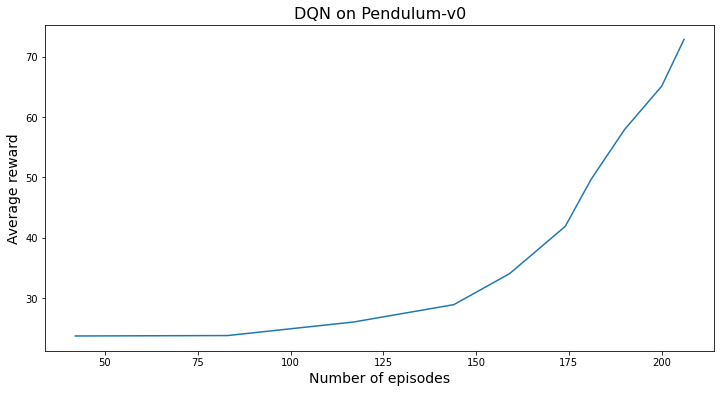

In [10]:
plt.figure(figsize=(12,6))
plt.plot(num_episodes_in_iter, mean_rewards)
plt.xlabel("Number of episodes", size = 14)
plt.ylabel("Average reward", size = 14)
plt.title("DQN on Pendulum-v0", size = 16)
plt.show()

## Task 1 

Let's be honest, most often you search for working solution without fully undestanding how algoritm works.

Here is practice for this! Go **search for best config in Rllib documentatin** for CartPole enviroment and DQN.

Use it for traininng and confirm that it better then default config.



In [11]:
tuned_config = {
        'framework': 'tf',
        'model': {
          'fcnet_hiddens': [64],
          'fcnet_activation': 'linear',
        },
        'n_step': 3}

trainer = dqn.DQNTrainer(config = tuned_config, env = CartpoleRlib)

2021-12-15 14:42:00,487	WARNING util.py:57 -- Install gputil for GPU system monitoring.


In [12]:
# We will train agent only for 10 iterations to check how it performs
num_training_iterations = 10
tuned_min_rewards = []
tuned_mean_rewards = []
tuned_max_rewards = []
tuned_num_episodes_in_iter = []

for iteration in tqdm(list(range(num_training_iterations))):
  result = trainer.train()
  tuned_mean_reward = result["episode_reward_mean"]
  tuned_max_reward = result["episode_reward_max"]
  tuned_min_reward = result["episode_reward_min"]
  tuned_num_episodes_in_this_iter = result["episodes_total"]

  tuned_min_rewards.append(tuned_min_reward)
  tuned_mean_rewards.append(tuned_mean_reward)
  tuned_max_rewards.append(tuned_max_reward)
  tuned_num_episodes_in_iter.append(tuned_num_episodes_in_this_iter)

  print("Min reward {}; Mean reward {}; Max reward {}.".format(tuned_min_reward, tuned_mean_reward, tuned_max_reward))

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Min reward 9.0; Mean reward 24.974358974358974; Max reward 73.0.
Min reward 9.0; Mean reward 22.602272727272727; Max reward 73.0.
Min reward 8.0; Mean reward 22.87; Max reward 70.0.
Min reward 8.0; Mean reward 29.15; Max reward 152.0.
Min reward 8.0; Mean reward 36.25; Max reward 154.0.
Min reward 8.0; Mean reward 43.42; Max reward 154.0.
Min reward 8.0; Mean reward 52.39; Max reward 198.0.
Min reward 8.0; Mean reward 60.19; Max reward 295.0.
Min reward 8.0; Mean reward 69.7; Max reward 295.0.
Min reward 8.0; Mean reward 79.69; Max reward 295.0.


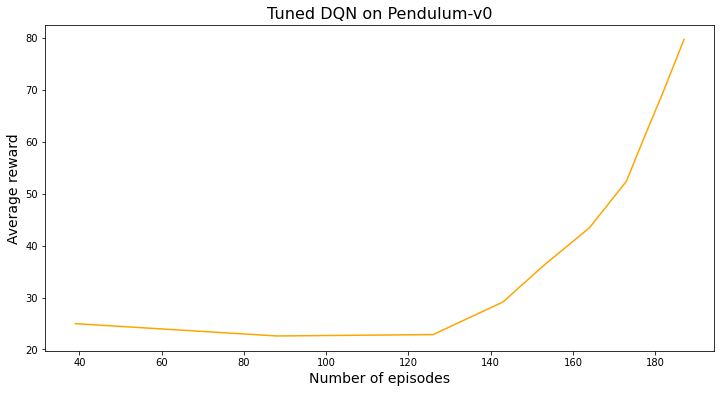

In [13]:
plt.figure(figsize=(12,6))
plt.plot(tuned_num_episodes_in_iter, tuned_mean_rewards, color = 'orange')
plt.xlabel("Number of episodes", size = 14)
plt.ylabel("Average reward", size = 14)
plt.title("Tuned DQN on Pendulum-v0", size = 16)
plt.show()

## Comparison

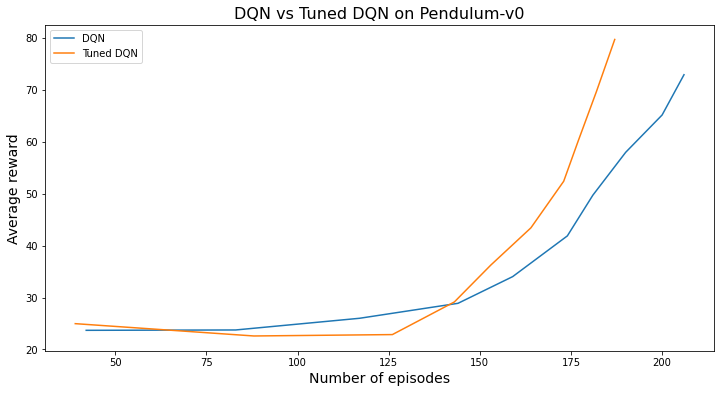

In [14]:
plt.figure(figsize=(12,6))
plt.plot(num_episodes_in_iter, mean_rewards, label = "DQN")
plt.plot(tuned_num_episodes_in_iter, tuned_mean_rewards, label = "Tuned DQN")
plt.legend(loc="upper left")
plt.xlabel("Number of episodes", size = 14)
plt.ylabel("Average reward", size = 14)
plt.title("DQN vs Tuned DQN on Pendulum-v0", size = 16)
plt.show()

## Also we will play with stable-baselines3

In [15]:
!pip install stable-baselines3[extra]

     |████████████████████████████████| 174 kB 4.3 MB/s 


Some hack for visualisation

In [16]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ge

stable_baselines verison 1 framework is originaly from OpenAI. This is 3rd iteration developed by other people.
It support [many](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html) algorithms.

For now we will try to solve the same CartPole env using A2C.
It uses policy iteration in similar way as REINFORCE.


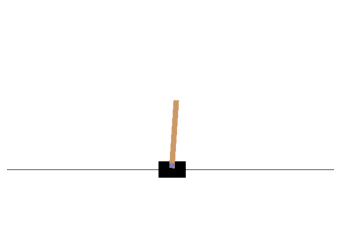

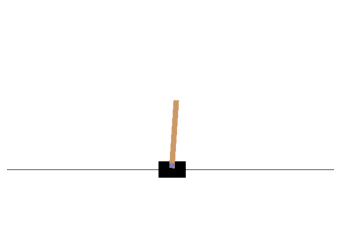

In [20]:
import gym

from stable_baselines3 import A2C
import gnwrapper

env = gym.make("CartPole-v1")
env = gnwrapper.Animation(env) # Start Xvfb


model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)

    env.render()

    if done:
      obs = env.reset()

env.close()


It works!

## Taks 2

For the last task you will train env "CartPole-v1" gym enviroment
using SAC algorithm. You do not require to undestand how SAC works!
The only thing you should know that "CartPole-v1" works with descrete actions like 0 or 1, but SAC only works with continius actions like 0.4555 or 0.9.

**Your task is to create wrapper for CartPole-v1 that will work with SAC.**

Example how to defined your own class above.
Note that usually the biggest part in solving RL problems is defining enviroment!

In [18]:
  class MyCartPole(gym.Env):
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,))
        self.observation_space = self.env.observation_space

    def reset(self):
        return np.array(self.env.reset())

    def step(self, action):
        return np.array(self.env.step(int(action[0] > 0.5)))

    def close(self):
        self.env.close()

    def render(self, **kwargs):
      self.env.render(kwargs)
    

In [19]:
import gym

from stable_baselines3 import SAC
import gnwrapper

env = MyCartPole()


#find what is MlpPolicy 
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    if done:
      obs = env.reset()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 20       |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2307     |
|    time_elapsed    | 0        |
|    total_timesteps | 80       |
---------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 20       |
| time/              |          |
|    episodes        | 8        |
|    fps             | 78       |
|    time_elapsed    | 2        |
|    total_timesteps | 160      |
| train/             |          |
|    actor_loss      | -2.37    |
|    critic_loss     | 0.145    |
|    ent_coef        | 0.983    |
|    ent_coef_loss   | -0.0291  |
|    learning_rate   | 0.0003   |
|    n_updates       | 59       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 20.3     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 51       |
|    time_elapsed    | 4        |
|    total_timesteps | 244      |
| train/             |          |
|    actor_loss      | -2.96    |
|    critic_loss     | 0.149    |
|    ent_coef 